https://github.com/masterTW/Tensorflow_NIMA_Food_Photo_Aesthetic_Evaluation

https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

In [15]:
!pip3 install --upgrade pip
!pip3 install tqdm seaborn

Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.0.2)


In [95]:
!cp /storage/smaller.tar /dev/shm/
!mkdir /dev/shm/data/
!mkdir /dev/shm/data/small_good
!tar -xf /dev/shm/smaller.tar -C /dev/shm/
!ls /dev/shm/

In [109]:
import os
import io
import tarfile
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import sys
import argparse
import os
import random
import shutil
import time

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [7]:
#%matplotlib inline

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results

print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [55]:
print(torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.get_device_name(0))

True 1 Quadro P5000


In [97]:
# Here we filter the well scored images from out dataset for use in our GAN
if len(os.listdir("/dev/shm/data/small_good/")) < 100:
  # load labels
  all_labels = pd.read_csv("/storage/AVA.txt",
                            sep = " ",
                            names=["id", 
                                  "img_id",
                                  "r_01", 
                                  "r_02", 
                                  "r_03", 
                                  "r_04", 
                                  "r_05", 
                                  "r_06", 
                                  "r_07", 
                                  "r_08", 
                                  "r_09", 
                                  "r_10",
                                  "im_tag_1",
                                  "im_tag_2",
                                  "challenge_id"])

  # normalize ratings
  all_labels["r_sum"] = all_labels.iloc[:,2:12].sum(axis=1)
  for i in range(1, 11):
    col_name = "r_" + str(i).rjust(2, "0")
    all_labels[col_name] = all_labels[col_name].astype("float") / all_labels["r_sum"]

  # reduce labels to the stuff we need
  reduced_labels = all_labels.drop(["id", "im_tag_1", "im_tag_2", "challenge_id", "r_sum"], axis = 1)

  for index, row in reduced_labels.iterrows():
    img_id = int(row["img_id"])
    img_name = str(img_id) + ".jpg"
    score = row[1:].to_numpy().dot(np.array([1,2,3,4,5,6,7,8,9,10]))
    if score > 6:
      try:
        shutil.copyfile(os.path.join("/dev/shm/smaller/", img_name), os.path.join("/dev/shm/data/small_good/", img_name))
      except:
        print(img_name + " does not exist")

953349.jpg does not exist
953645.jpg does not exist
953897.jpg does not exist
567829.jpg does not exist
638163.jpg does not exist
104855.jpg does not exist
430454.jpg does not exist


In [98]:
# Root directory for dataset
dataroot = "/dev/shm/data/"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 64

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 128

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 10

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Magnitude of noise to add to generator output and real images
img_noise_mag = 0.01

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.RandomHorizontalFlip(p=0.5),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

print(device, batch_size, len(dataloader))

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8), dpi=128)
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [44]:
# custom weights initialization called on netG and netD
def weights_init(m):
  classname = m.__class__.__name__
  if classname.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0.0, 0.02)
  elif classname.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1.0, 0.02)
    nn.init.constant_(m.bias.data, 0)

In [45]:
# Generator Code

class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      # input is Z, going into a convolution
      nn.ConvTranspose2d(in_channels=nz, 
                         out_channels=ngf*16, 
                         kernel_size=4, 
                         stride=1, 
                         padding=0, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*16),
      nn.ReLU(True),
      # state size. (ngf*16) x 4 x 4
      nn.ConvTranspose2d(in_channels=ngf*16, 
                         out_channels=ngf*8, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*8),
      nn.ReLU(True),
      # state size. (ngf*8) x 8 x 8
      nn.ConvTranspose2d(in_channels=ngf*8, 
                         out_channels=ngf*4, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*4),
      nn.ReLU(True),
      # state size. (ngf*4) x 16 x 16
      nn.ConvTranspose2d(in_channels=ngf*4, 
                         out_channels=ngf*2, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf*2),
      nn.ReLU(True),
      # state size. (ngf*2) x 32 x 32
      nn.ConvTranspose2d(in_channels=ngf*2, 
                         out_channels=ngf, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.BatchNorm2d(num_features=ngf),
      nn.ReLU(True),
      # state size. (ngf) x 64 x 46
      nn.ConvTranspose2d(in_channels=ngf, 
                         out_channels=nc, 
                         kernel_size=4, 
                         stride=2, 
                         padding=1, 
                         bias=False),
      nn.Tanh()
      # state size. (nc) x 128 x 128
    )
  def forward(self, input):
      return self.main(input)

In [101]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#netG.apply(weights_init)

# Print the model
print(netG)
print(sum(p.numel() for p in netG.parameters()))

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): BatchN

In [47]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(
      # input is (nc) x 128 x 128
      nn.Conv2d(in_channels=nc, 
                out_channels=ndf,
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf) x 64 x 64
      nn.Conv2d(in_channels=ndf, 
                out_channels=ndf*2,  
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False),
      nn.BatchNorm2d(num_features=ndf*2),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*2) x 32 x 32
      nn.Conv2d(in_channels=ndf*2,
                out_channels=ndf*4,  
                kernel_size=4, 
                stride=2, 
                padding=1,
                bias=False),
      nn.BatchNorm2d(num_features=ndf*4),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*4) x 16 x 16
      nn.Conv2d(in_channels=ndf*4, 
                out_channels=ndf*8, 
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False),
      nn.BatchNorm2d(num_features=ndf*8),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*8) x 8 x 8
      nn.Conv2d(in_channels=ndf*8, 
                out_channels=ndf*16,  
                kernel_size=4, 
                stride=2, 
                padding=1, 
                bias=False),
      nn.BatchNorm2d(num_features=ndf*16),
      nn.LeakyReLU(0.2, inplace=True),
      # state size. (ndf*16) x 4 x 4
      nn.Conv2d(in_channels=ndf*16,
                out_channels=1,  
                kernel_size=4, 
                stride=1,
                padding=0, 
                bias=False),
      nn.Sigmoid()
    )
  def forward(self, input):
    return self.main(input)

In [102]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
  netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
#netD.apply(weights_init)

# Print the model
print(netD)
print(sum(p.numel() for p in netD.parameters()))

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(1024, eps=1e-05

In [103]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [104]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in tqdm(range(num_epochs)):
  # For each batch in the dataloader
  for i, data in tqdm(enumerate(dataloader, 0), total=len(dataloader)):

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real_cpu = data[0].to(device)
    b_size = real_cpu.size(0)
    img_noise = torch.randn(b_size, nc, image_size, image_size, device=device) * img_noise_mag
    label = torch.full((b_size,), real_label, device=device)
    # Forward pass real batch through D
    output = netD(real_cpu + img_noise).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()
    D_x = output.mean().item()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    img_noise = torch.randn(b_size, nc, image_size, image_size, device=device) * img_noise_mag
    label.fill_(fake_label)
    # Classify all fake batch with D
    output = netD(fake + img_noise).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output, label)
    # Calculate the gradients for this batch
    errD_fake.backward()
    D_G_z1 = output.mean().item()
    # Add the gradients from the all-real and all-fake batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    # we do two steps here to balance the generator and discriminator
    ###########################
    #first step
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output = netD(fake.detach() + img_noise).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G xxx
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizerG.step()

    # second step
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    img_noise = torch.randn(b_size, nc, image_size, image_size, device=device) * img_noise_mag
    # Classify all fake batch with D
    output = netD(fake + img_noise).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizerG.step()
    
    # third step
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Generate batch of latent vectors
    noise = torch.randn(b_size, nz, 1, 1, device=device)
    # Generate fake image batch with G
    fake = netG(noise)
    img_noise = torch.randn(b_size, nc, image_size, image_size, device=device) * img_noise_mag
    # Classify all fake batch with D
    output = netD(fake + img_noise).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output, label)
    # Calculate gradients for G
    errG.backward()
    D_G_z2 = output.mean().item()
    # Update G
    optimizerG.step()

    # Output training stats
    if i % 100 == 0:
      print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
        % (epoch+1, num_epochs, i, len(dataloader),
            errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

    # Save Losses for plotting later
    G_losses.append(errG.item())
    D_losses.append(errD.item())

    # Check how the generator is doing by saving G's output on fixed_noise
    if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
      with torch.no_grad():
        fake = netG(fixed_noise).detach().cpu()
      img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

    iters += 1

Starting Training Loop...


[1/10][0/777]	Loss_D: 1.4592	Loss_G: 1.0544	D(x): 0.5330	D(G(z)): 0.5520 / 0.3635
[1/10][100/777]	Loss_D: 1.2259	Loss_G: 2.3811	D(x): 0.6970	D(G(z)): 0.5614 / 0.1062
[1/10][200/777]	Loss_D: 1.3969	Loss_G: 0.8001	D(x): 0.5169	D(G(z)): 0.4936 / 0.4604
[1/10][300/777]	Loss_D: 1.5837	Loss_G: 0.8416	D(x): 0.4418	D(G(z)): 0.4907 / 0.4381
[1/10][400/777]	Loss_D: 1.4172	Loss_G: 0.7594	D(x): 0.4530	D(G(z)): 0.4422 / 0.4866
[1/10][500/777]	Loss_D: 1.3539	Loss_G: 0.7614	D(x): 0.5135	D(G(z)): 0.4805 / 0.4815
[1/10][600/777]	Loss_D: 1.4164	Loss_G: 0.6181	D(x): 0.5127	D(G(z)): 0.5189 / 0.5459
[1/10][700/777]	Loss_D: 1.5288	Loss_G: 0.6767	D(x): 0.4269	D(G(z)): 0.4379 / 0.5177



[2/10][0/777]	Loss_D: 1.3190	Loss_G: 0.8919	D(x): 0.5511	D(G(z)): 0.4978 / 0.4205
[2/10][100/777]	Loss_D: 1.4889	Loss_G: 0.7336	D(x): 0.4182	D(G(z)): 0.4484 / 0.4830
[2/10][200/777]	Loss_D: 1.5655	Loss_G: 0.8864	D(x): 0.4258	D(G(z)): 0.4761 / 0.4180
[2/10][300/777]	Loss_D: 1.3764	Loss_G: 0.7041	D(x): 0.5341	D(G(z)): 0.5100 / 0.5010
[2/10][400/777]	Loss_D: 1.4790	Loss_G: 0.7605	D(x): 0.4450	D(G(z)): 0.4647 / 0.4715
[2/10][500/777]	Loss_D: 1.4334	Loss_G: 0.8606	D(x): 0.5137	D(G(z)): 0.5153 / 0.4265
[2/10][600/777]	Loss_D: 1.5062	Loss_G: 0.7591	D(x): 0.4424	D(G(z)): 0.4833 / 0.4758
[2/10][700/777]	Loss_D: 1.4138	Loss_G: 0.6841	D(x): 0.5613	D(G(z)): 0.5481 / 0.5112



[3/10][0/777]	Loss_D: 1.4321	Loss_G: 0.6203	D(x): 0.5266	D(G(z)): 0.5194 / 0.5426
[3/10][100/777]	Loss_D: 1.5469	Loss_G: 0.6991	D(x): 0.5050	D(G(z)): 0.5563 / 0.5073
[3/10][200/777]	Loss_D: 1.5093	Loss_G: 0.6618	D(x): 0.4121	D(G(z)): 0.4455 / 0.5216
[3/10][300/777]	Loss_D: 1.3930	Loss_G: 0.7522	D(x): 0.4604	D(G(z)): 0.4516 / 0.4791
[3/10][400/777]	Loss_D: 1.3988	Loss_G: 0.7740	D(x): 0.5004	D(G(z)): 0.4914 / 0.4811
[3/10][500/777]	Loss_D: 1.3974	Loss_G: 0.7396	D(x): 0.5009	D(G(z)): 0.5015 / 0.4804
[3/10][600/777]	Loss_D: 1.4045	Loss_G: 0.6481	D(x): 0.5075	D(G(z)): 0.5076 / 0.5272
[3/10][700/777]	Loss_D: 1.3580	Loss_G: 0.8183	D(x): 0.4849	D(G(z)): 0.4629 / 0.4459



[4/10][0/777]	Loss_D: 1.4485	Loss_G: 0.6296	D(x): 0.5134	D(G(z)): 0.5299 / 0.5363
[4/10][100/777]	Loss_D: 1.4854	Loss_G: 0.7049	D(x): 0.4450	D(G(z)): 0.4860 / 0.4964
[4/10][200/777]	Loss_D: 1.4145	Loss_G: 0.5688	D(x): 0.4617	D(G(z)): 0.4677 / 0.5682
[4/10][300/777]	Loss_D: 1.4444	Loss_G: 0.7198	D(x): 0.4586	D(G(z)): 0.4798 / 0.4902
[4/10][400/777]	Loss_D: 1.4134	Loss_G: 0.7127	D(x): 0.5375	D(G(z)): 0.5448 / 0.4915
[4/10][500/777]	Loss_D: 1.4651	Loss_G: 0.6472	D(x): 0.4847	D(G(z)): 0.5164 / 0.5247
[4/10][600/777]	Loss_D: 1.4577	Loss_G: 0.6500	D(x): 0.5186	D(G(z)): 0.5423 / 0.5249
[4/10][700/777]	Loss_D: 1.4189	Loss_G: 0.8668	D(x): 0.4792	D(G(z)): 0.4914 / 0.4227



[5/10][0/777]	Loss_D: 1.3892	Loss_G: 0.8006	D(x): 0.5159	D(G(z)): 0.5139 / 0.4503
[5/10][100/777]	Loss_D: 1.4226	Loss_G: 0.6036	D(x): 0.5365	D(G(z)): 0.5473 / 0.5489
[5/10][200/777]	Loss_D: 1.4879	Loss_G: 0.8111	D(x): 0.4572	D(G(z)): 0.4835 / 0.4455
[5/10][300/777]	Loss_D: 1.4256	Loss_G: 0.7604	D(x): 0.5204	D(G(z)): 0.5355 / 0.4689
[5/10][400/777]	Loss_D: 1.4342	Loss_G: 0.7512	D(x): 0.4697	D(G(z)): 0.4865 / 0.4728
[5/10][500/777]	Loss_D: 1.3342	Loss_G: 0.8765	D(x): 0.4877	D(G(z)): 0.4557 / 0.4211
[5/10][600/777]	Loss_D: 1.3536	Loss_G: 0.6442	D(x): 0.5525	D(G(z)): 0.5231 / 0.5297
[5/10][700/777]	Loss_D: 1.3916	Loss_G: 0.7097	D(x): 0.4765	D(G(z)): 0.4706 / 0.4934



[6/10][0/777]	Loss_D: 1.3795	Loss_G: 0.8705	D(x): 0.5852	D(G(z)): 0.5627 / 0.4229
[6/10][100/777]	Loss_D: 1.3247	Loss_G: 0.8160	D(x): 0.5247	D(G(z)): 0.4833 / 0.4484
[6/10][200/777]	Loss_D: 1.4066	Loss_G: 0.6863	D(x): 0.4596	D(G(z)): 0.4608 / 0.5082
[6/10][300/777]	Loss_D: 1.3666	Loss_G: 0.7922	D(x): 0.4924	D(G(z)): 0.4776 / 0.4545
[6/10][400/777]	Loss_D: 1.3362	Loss_G: 0.6219	D(x): 0.5205	D(G(z)): 0.4878 / 0.5426
[6/10][500/777]	Loss_D: 1.4488	Loss_G: 0.8044	D(x): 0.4624	D(G(z)): 0.4764 / 0.4528
[6/10][600/777]	Loss_D: 1.3669	Loss_G: 0.6511	D(x): 0.5014	D(G(z)): 0.4836 / 0.5245
[6/10][700/777]	Loss_D: 1.4030	Loss_G: 0.8612	D(x): 0.5316	D(G(z)): 0.5273 / 0.4258



[7/10][0/777]	Loss_D: 1.5304	Loss_G: 0.6548	D(x): 0.4250	D(G(z)): 0.4819 / 0.5231
[7/10][100/777]	Loss_D: 1.4200	Loss_G: 0.8304	D(x): 0.4896	D(G(z)): 0.4973 / 0.4413
[7/10][200/777]	Loss_D: 1.2755	Loss_G: 0.9600	D(x): 0.6421	D(G(z)): 0.5545 / 0.3961
[7/10][300/777]	Loss_D: 1.4091	Loss_G: 0.8684	D(x): 0.5282	D(G(z)): 0.5257 / 0.4251
[7/10][400/777]	Loss_D: 1.5205	Loss_G: 1.8192	D(x): 0.7421	D(G(z)): 0.6764 / 0.1792
[7/10][500/777]	Loss_D: 1.4017	Loss_G: 0.8911	D(x): 0.5257	D(G(z)): 0.5192 / 0.4184
[7/10][600/777]	Loss_D: 1.2343	Loss_G: 0.9436	D(x): 0.4673	D(G(z)): 0.3379 / 0.3990
[7/10][700/777]	Loss_D: 1.2443	Loss_G: 0.7562	D(x): 0.6351	D(G(z)): 0.5158 / 0.4830



[8/10][0/777]	Loss_D: 1.1679	Loss_G: 1.4012	D(x): 0.7215	D(G(z)): 0.5548 / 0.2604
[8/10][100/777]	Loss_D: 1.0977	Loss_G: 1.4094	D(x): 0.4203	D(G(z)): 0.1705 / 0.2663
[8/10][200/777]	Loss_D: 1.1350	Loss_G: 1.8073	D(x): 0.7423	D(G(z)): 0.5281 / 0.1761
[8/10][300/777]	Loss_D: 1.1333	Loss_G: 2.2461	D(x): 0.8215	D(G(z)): 0.5764 / 0.1198
[8/10][400/777]	Loss_D: 0.9926	Loss_G: 2.5943	D(x): 0.7659	D(G(z)): 0.4924 / 0.0936
[8/10][500/777]	Loss_D: 1.1076	Loss_G: 1.2757	D(x): 0.6140	D(G(z)): 0.4176 / 0.3199
[8/10][600/777]	Loss_D: 0.7130	Loss_G: 3.2414	D(x): 0.8539	D(G(z)): 0.3879 / 0.0492
[8/10][700/777]	Loss_D: 1.2938	Loss_G: 1.8445	D(x): 0.5895	D(G(z)): 0.4390 / 0.2177



[9/10][0/777]	Loss_D: 0.6015	Loss_G: 1.9180	D(x): 0.6343	D(G(z)): 0.0955 / 0.2063
[9/10][100/777]	Loss_D: 0.5134	Loss_G: 3.6756	D(x): 0.8841	D(G(z)): 0.3088 / 0.0341
[9/10][200/777]	Loss_D: 0.1372	Loss_G: 2.4491	D(x): 0.9468	D(G(z)): 0.0768 / 0.1031
[9/10][300/777]	Loss_D: 0.6746	Loss_G: 1.2690	D(x): 0.6660	D(G(z)): 0.1998 / 0.3316
[9/10][400/777]	Loss_D: 0.6814	Loss_G: 1.1517	D(x): 0.6658	D(G(z)): 0.2000 / 0.3550
[9/10][500/777]	Loss_D: 0.5114	Loss_G: 2.3854	D(x): 0.8525	D(G(z)): 0.2811 / 0.1105
[9/10][600/777]	Loss_D: 0.4054	Loss_G: 2.7891	D(x): 0.8957	D(G(z)): 0.2326 / 0.0821
[9/10][700/777]	Loss_D: 0.5633	Loss_G: 3.5913	D(x): 0.7831	D(G(z)): 0.2469 / 0.0331



[10/10][0/777]	Loss_D: 0.2530	Loss_G: 3.0069	D(x): 0.8349	D(G(z)): 0.0590 / 0.0658
[10/10][100/777]	Loss_D: 0.6142	Loss_G: 4.1365	D(x): 0.6077	D(G(z)): 0.0166 / 0.0242
[10/10][200/777]	Loss_D: 0.3614	Loss_G: 5.1528	D(x): 0.9869	D(G(z)): 0.2818 / 0.0084
[10/10][300/777]	Loss_D: 1.1074	Loss_G: 1.6901	D(x): 0.3932	D(G(z)): 0.0321 / 0.2264
[10/10][400/777]	Loss_D: 0.8744	Loss_G: 1.0436	D(x): 0.5215	D(G(z)): 0.1085 / 0.4121
[10/10][500/777]	Loss_D: 0.2368	Loss_G: 3.0182	D(x): 0.8429	D(G(z)): 0.0492 / 0.0624
[10/10][600/777]	Loss_D: 0.5042	Loss_G: 3.0619	D(x): 0.7856	D(G(z)): 0.1915 / 0.0703
[10/10][700/777]	Loss_D: 0.1640	Loss_G: 2.0259	D(x): 0.8994	D(G(z)): 0.0505 / 0.1809




In [113]:
output_ts = time.strftime("%Y%m%d-%H%M%S")
torch.save(netG.state_dict(), "/storage/pytorch_nima_ps_v1_netg" + output_ts)
torch.save(netD.state_dict(), "/storage/pytorch_nima_ps_v1_netd" + output_ts)

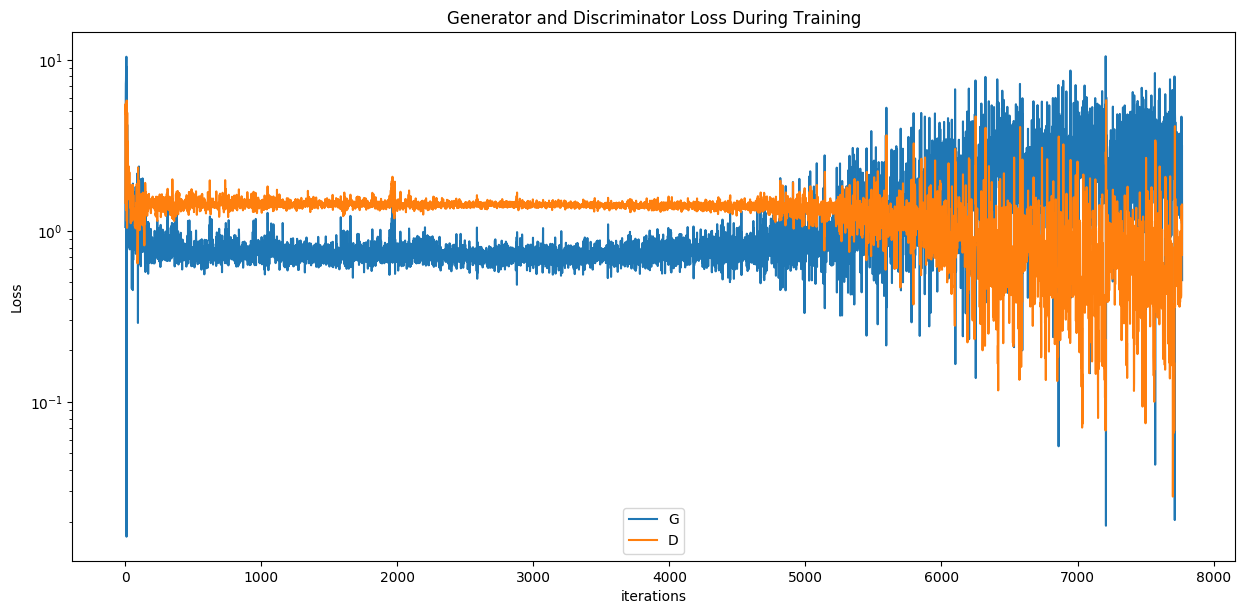

In [105]:
plt.figure(figsize=(15,7), dpi=100)
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.yscale("log")
plt.legend()
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,8), dpi=32)
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(16,8), dpi=128)
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
# Plot the fake images from the last epoch
plt.figure(figsize=(8,8), dpi=128)
plt.axis("off")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()